This dataset was obtained from Kaggle. You can download from this [link](https://www.kaggle.com/datasets/shivachandel/kc-house-data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.express as px
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('darkgrid')

# 1. EDA

## 1.x. Domain Understanding

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
houses = pd.read_csv('datasets/kc_house_data.csv').iloc[:, 2:]
houses.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900.0         3       1.00         1180      5650     1.0           0   
1  538000.0         3       2.25         2570      7242     2.0           0   
2  180000.0         2       1.00          770     10000     1.0           0   
3  604000.0         4       3.00         1960      5000     1.0           0   
4  510000.0         3       2.00         1680      8080     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7      1180.0              0      1955             0   
1     0          3      7      2170.0            400      1951          1991   
2     0          3      6       770.0              0      1933             0   
3     0          5      7      1050.0            910      1965             0   
4     0          3      8      1680.0              0      1987             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98125  47.7210 -122.319           1690        7639  
2    98028  47.7379 -122.233           2720        8062  
3    98136  47.5208 -122.393           1360        5000  
4    98074  47.6168 -122.045           1800        7503

In [4]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21611 non-null  float64
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  zipcode        21613 non-null  int64  
 15  lat            21613 non-null  float64
 16  long           21613 non-null  float64
 17  sqft_living15  21613 non-null  int64  
 18  sqft_l

In [5]:
houses.nunique()

price            4028
bedrooms           13
bathrooms          30
sqft_living      1038
sqft_lot         9782
floors              6
waterfront          2
view                5
condition           5
grade              12
sqft_above        946
sqft_basement     306
yr_built          116
yr_renovated       70
zipcode            70
lat              5034
long              752
sqft_living15     777
sqft_lot15       8689
dtype: int64

In [6]:
houses.describe()

price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  2.161300e+04   
mean   5.400881e+05      3.370842      2.114757   2079.899736  1.510697e+04   
std    3.671272e+05      0.930062      0.770163    918.440897  4.142051e+04   
min    7.500000e+04      0.000000      0.000000    290.000000  5.200000e+02   
25%    3.219500e+05      3.000000      1.750000   1427.000000  5.040000e+03   
50%    4.500000e+05      3.000000      2.250000   1910.000000  7.618000e+03   
75%    6.450000e+05      4.000000      2.500000   2550.000000  1.068800e+04   
max    7.700000e+06     33.000000      8.000000  13540.000000  1.651359e+06   

             floors    waterfront          view     condition         grade  \
count  21613.000000  21613.000000  21613.000000  21613.000000  21613.000000   
mean       1.494309      0.007542      0.234303      3.409430      7.656873   
std        0.539989      0.086517      0.766318      0.650743      1.175459   
min        1.000000      0.000000      0.000000      1.000000      1.000000   
25%        1.000000      0.000000      0.000000      3.000000      7.000000   
50%        1.500000      0.000000      0.000000      3.000000      7.000000   
75%        2.000000      0.000000      0.000000      4.000000      8.000000   
max        3.500000      1.000000      4.000000      5.000000     13.000000   

         sqft_above  sqft_basement      yr_built  yr_renovated       zipcode  \
count  21611.000000   21613.000000  21613.000000  21613.000000  21613.000000   
mean    1788.396095     291.509045   1971.005136     84.402258  98077.939805   
std      828.128162     442.575043     29.373411    401.679240     53.505026   
min      290.000000       0.000000   1900.000000      0.000000  98001.000000   
25%     1190.000000       0.000000   1951.000000      0.000000  98033.000000   
50%     1560.000000       0.000000   1975.000000      0.000000  98065.000000   
75%     2210.000000     560.000000   1997.000000      0.000000  98118.000000   
max     9410.000000    4820.000000   2015.000000   2015.000000  98199.000000   

                lat          long  sqft_living15     sqft_lot15  
count  21613.000000  21613.000000   21613.000000   21613.000000  
mean      47.560053   -122.213896    1986.552492   12768.455652  
std        0.138564      0.140828     685.391304   27304.179631  
min       47.155900   -122.519000     399.000000     651.000000  
25%       47.471000   -122.328000    1490.000000    5100.000000  
50%       47.571800   -122.230000    1840.000000    7620.000000  
75%       47.678000   -122.125000    2360.000000   10083.000000  
max       47.777600   -121.315000    6210.000000  871200.000000

In [62]:
houses['view'].unique()

array([0, 3, 4, 2, 1])

In [8]:
houses[houses['sqft_basement'] == 0].shape[0]

13126

In [9]:
len(houses[houses['yr_renovated'] == 0])

20699

In [10]:
houses['zipcode'].nunique()

70

In [50]:
houses['bedrooms'].unique()

array([ 3,  2,  4,  5,  1,  6,  7,  0,  8,  9, 11, 10, 33])

In [51]:
houses[houses['bedrooms'] == 33]

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
15870  640000.0        33       1.75         1620      6000     1.0   

       waterfront  view  condition  grade  sqft_above  sqft_basement  \
15870           0     0          5      7      1040.0          580.0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
15870      1947           NaN    98103  47.6878 -122.331           1330   

       sqft_lot15  
15870        4700

In [56]:
houses['grade'].unique()

array([ 7,  6,  8, 11,  9,  5, 10, 12,  4,  3, 13,  1])

In [65]:
houses['bathrooms'].unique()

array([1.  , 2.25, 3.  , 2.  , 4.5 , 1.5 , 2.5 , 1.75, 2.75, 3.25, 4.  ,
       3.5 , 0.75, 4.75, 5.  , 4.25, 3.75, 0.  , 1.25, 5.25, 6.  , 0.5 ,
       5.5 , 6.75, 5.75, 8.  , 7.5 , 7.75, 6.25, 6.5 ])

## 1.xx. Data Manipulation

In [11]:
houses = houses.replace({'sqft_basement' : 0, 'yr_renovated' : 0}, np.nan)

In [12]:
houses.isnull().sum()

price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront           0
view                 0
condition            0
grade                0
sqft_above           2
sqft_basement    13126
yr_built             0
yr_renovated     20699
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
dtype: int64

## 1.xxx. Correlation Analysis

In [13]:
houses_corr = houses.corr(numeric_only=int)
houses_corr

price  bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
price          1.000000  0.308350   0.525138     0.702035  0.089661  0.256794   
bedrooms       0.308350  1.000000   0.515884     0.576671  0.031703  0.175429   
bathrooms      0.525138  0.515884   1.000000     0.754665  0.087740  0.500653   
sqft_living    0.702035  0.576671   0.754665     1.000000  0.172826  0.353949   
sqft_lot       0.089661  0.031703   0.087740     0.172826  1.000000 -0.005201   
floors         0.256794  0.175429   0.500653     0.353949 -0.005201  1.000000   
waterfront     0.266369 -0.006582   0.063744     0.103818  0.021604  0.023698   
view           0.397293  0.079532   0.187737     0.284611  0.074710  0.029444   
condition      0.036362  0.028472  -0.124982    -0.058753 -0.008958 -0.263768   
grade          0.667434  0.356967   0.664983     0.762704  0.113621  0.458183   
sqft_above     0.605567  0.477616   0.685363     0.876644  0.183511  0.523899   
sqft_basement  0.407308  0.433152   0.413126     0.717299  0.155285 -0.112064   
yr_built       0.054012  0.154178   0.506019     0.318049  0.053080  0.489319   
yr_renovated   0.127894  0.158168   0.254640     0.140647 -0.067762  0.052860   
zipcode       -0.053203 -0.152668  -0.203866    -0.199430 -0.129574 -0.059121   
lat            0.307003 -0.008931   0.024573     0.052529 -0.085683  0.049614   
long           0.021626  0.129473   0.223042     0.240223  0.229521  0.125419   
sqft_living15  0.585379  0.391638   0.568634     0.756420  0.144608  0.279885   
sqft_lot15     0.082447  0.029244   0.087175     0.183286  0.718557 -0.011269   

               waterfront      view  condition     grade  sqft_above  \
price            0.266369  0.397293   0.036362  0.667434    0.605567   
bedrooms        -0.006582  0.079532   0.028472  0.356967    0.477616   
bathrooms        0.063744  0.187737  -0.124982  0.664983    0.685363   
sqft_living      0.103818  0.284611  -0.058753  0.762704    0.876644   
sqft_lot         0.021604  0.074710  -0.008958  0.113621    0.183511   
floors           0.023698  0.029444  -0.263768  0.458183    0.523899   
waterfront       1.000000  0.401857   0.016653  0.082775    0.072074   
view             0.401857  1.000000   0.045990  0.251321    0.167648   
condition        0.016653  0.045990   1.000000 -0.144674   -0.158206   
grade            0.082775  0.251321  -0.144674  1.000000    0.755924   
sqft_above       0.072074  0.167648  -0.158206  0.755924    1.000000   
sqft_basement    0.112862  0.278397   0.163494  0.371055    0.386803   
yr_built        -0.026161 -0.053440  -0.361417  0.446963    0.423915   
yr_renovated    -0.102677 -0.054334  -0.368537  0.243086    0.064046   
zipcode          0.030285  0.084827   0.003026 -0.184862   -0.261192   
lat             -0.014274  0.006157  -0.014941  0.114084   -0.000810   
long            -0.041910 -0.078400  -0.106500  0.198372    0.343800   
sqft_living15    0.086463  0.280439  -0.092824  0.713202    0.731871   
sqft_lot15       0.030703  0.072575  -0.003406  0.119248    0.194048   

               sqft_basement  yr_built  yr_renovated   zipcode       lat  \
price               0.407308  0.054012      0.127894 -0.053203  0.307003   
bedrooms            0.433152  0.154178      0.158168 -0.152668 -0.008931   
bathrooms           0.413126  0.506019      0.254640 -0.203866  0.024573   
sqft_living         0.717299  0.318049      0.140647 -0.199430  0.052529   
sqft_lot            0.155285  0.053080     -0.067762 -0.129574 -0.085683   
floors             -0.112064  0.489319      0.052860 -0.059121  0.049614   
waterfront          0.112862 -0.026161     -0.102677  0.030285 -0.014274   
view                0.278397 -0.053440     -0.054334  0.084827  0.006157   
condition           0.163494 -0.361417     -0.368537  0.003026 -0.014941   
grade               0.371055  0.446963      0.243086 -0.184862  0.114084   
sqft_above          0.386803  0.423915      0.064046 -0.261192 -0.000810   
sqft_basement       1.000000  0.012692      

## 1.xxxx. Data Visualization

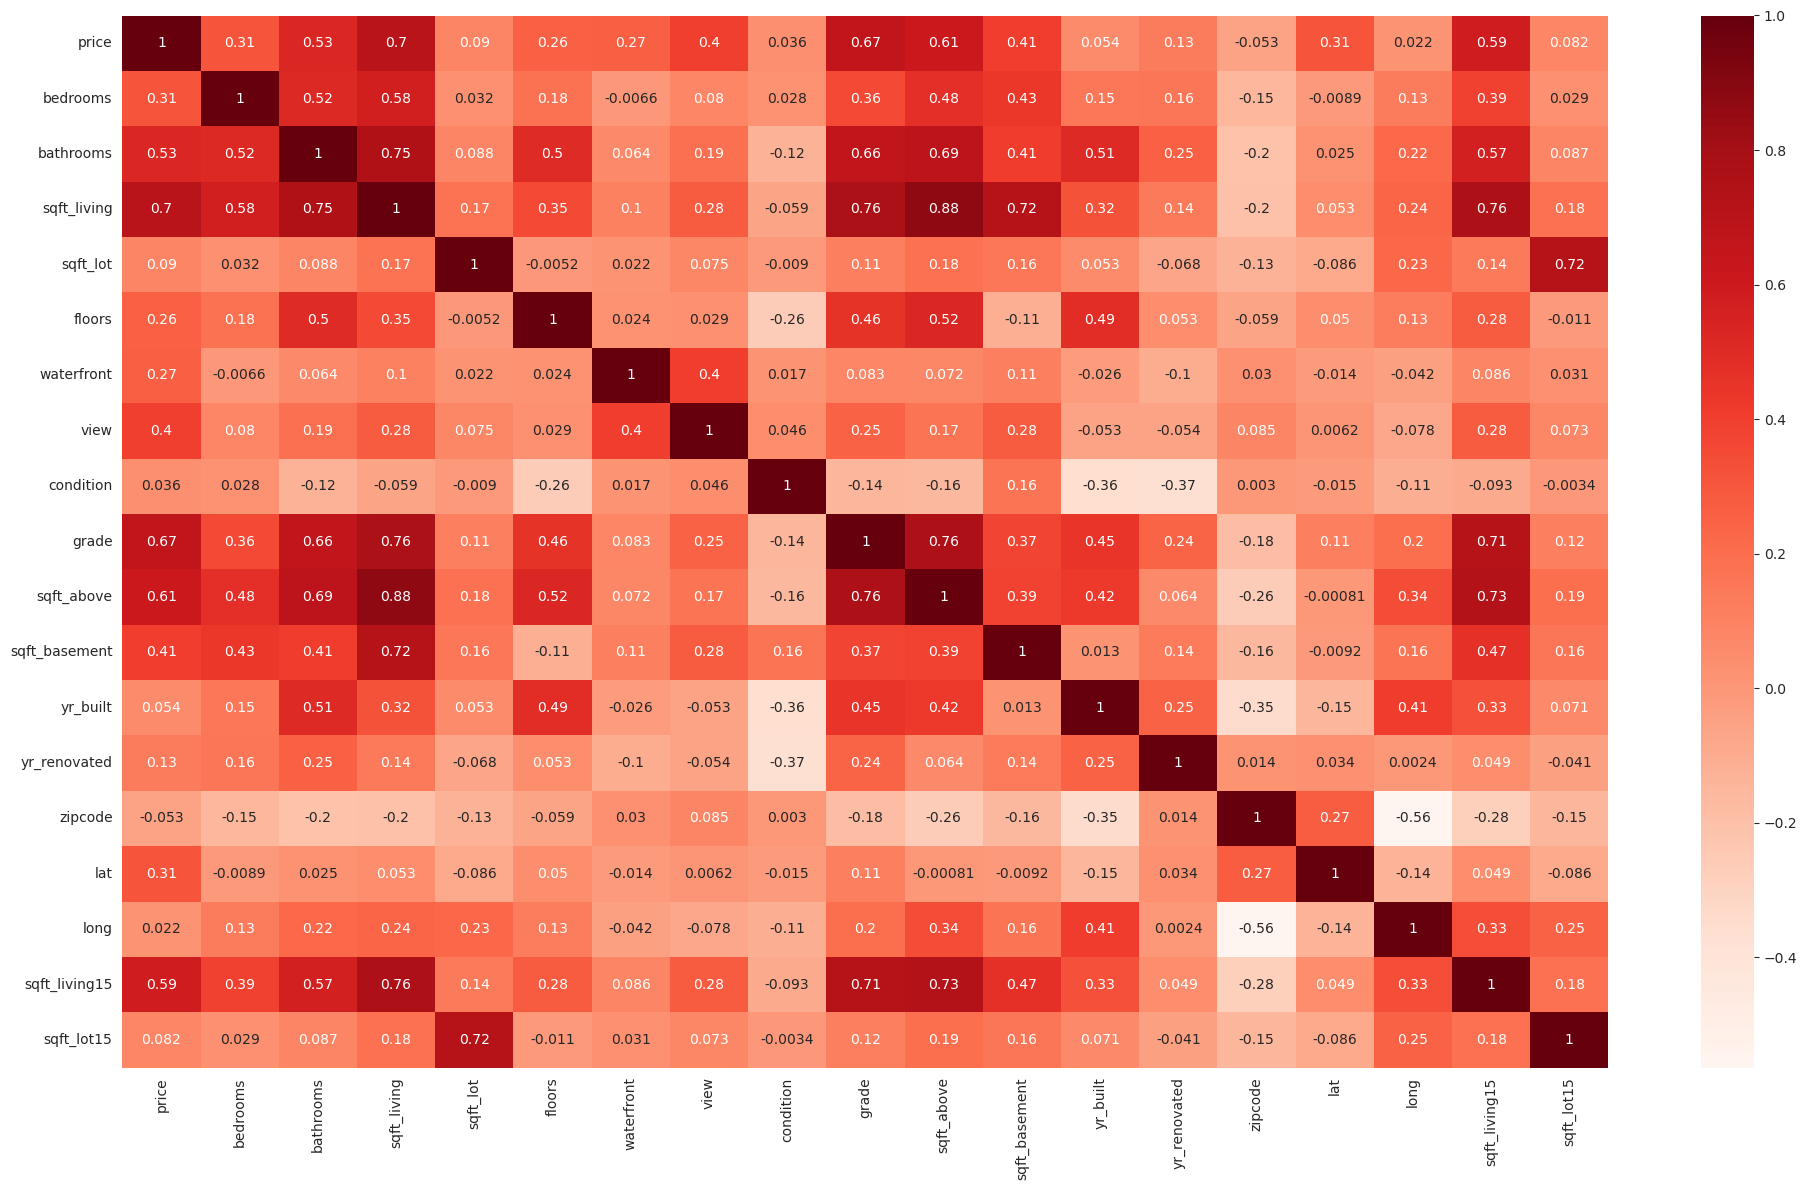

In [14]:
fig, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(houses_corr, annot=True, cmap='Reds')
plt.tight_layout()

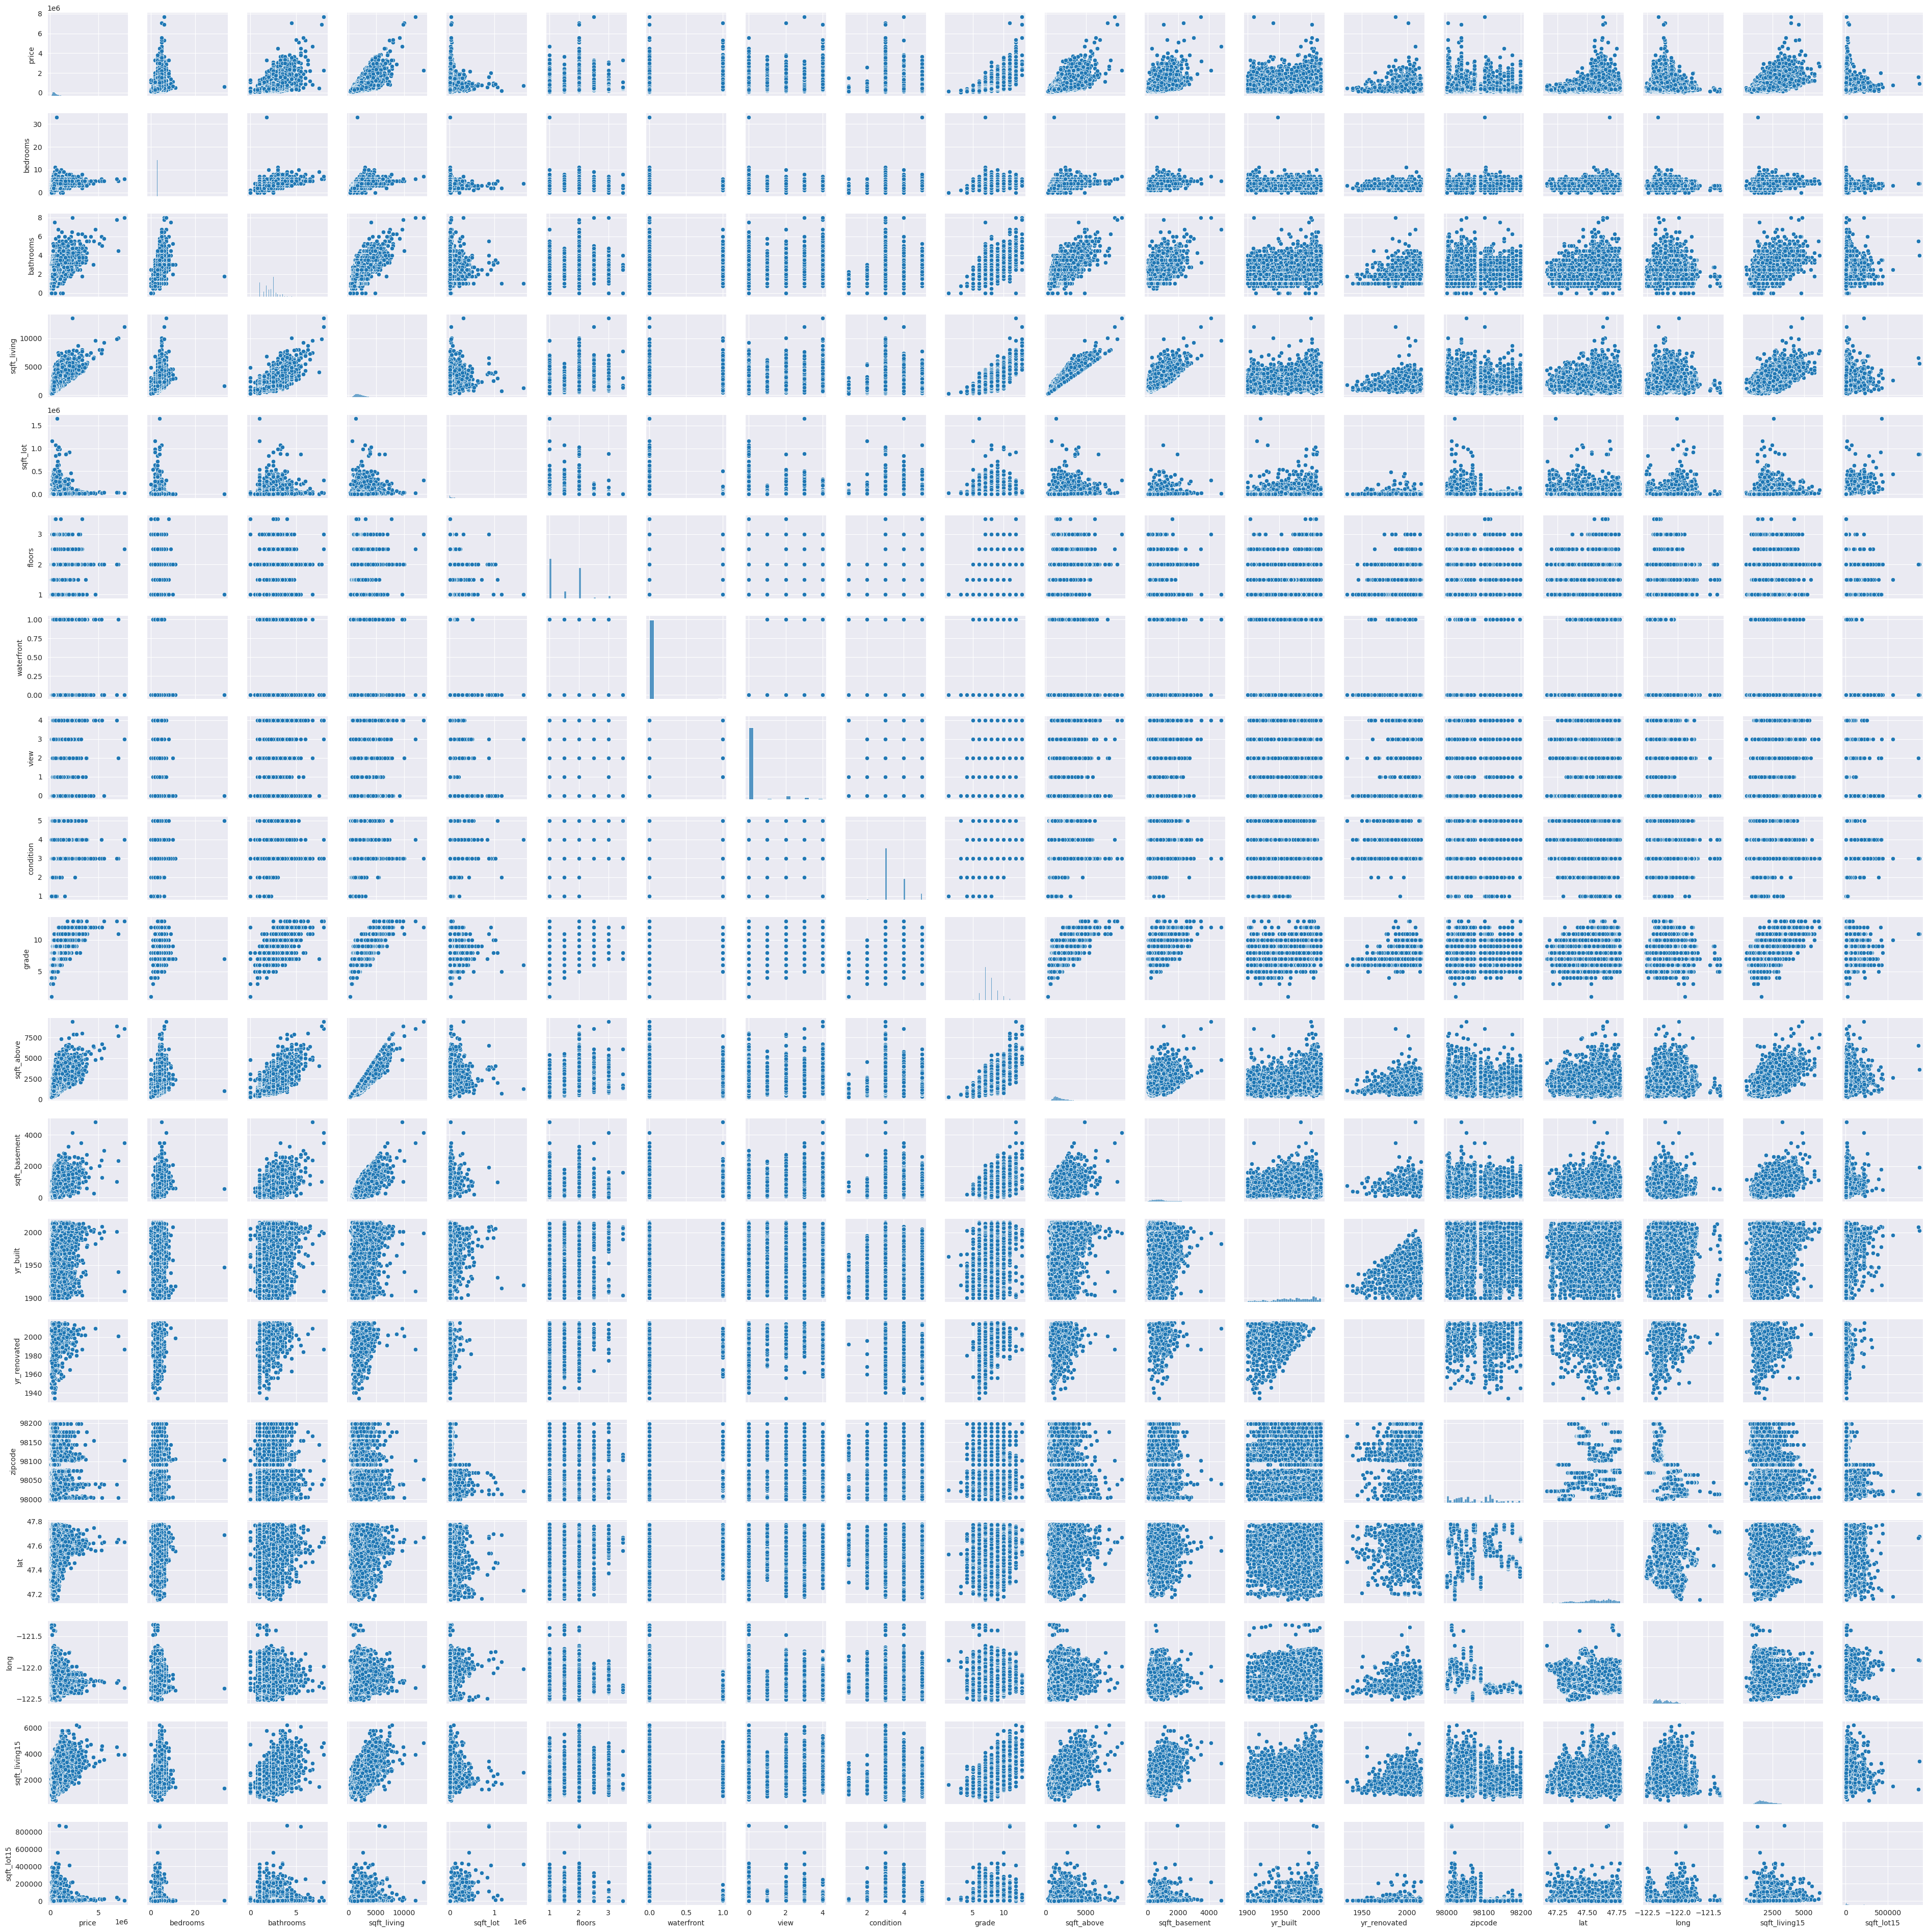

In [15]:
pairplot = sns.pairplot(data=houses, height=2)
plt.tight_layout()

In [72]:
bedrooms_price_df = pd.DataFrame({'The number of bedrooms' : sorted(houses['bedrooms'].unique()),
                                  'Price' : houses.groupby('bedrooms')['price'].mean()})
px.histogram(bedrooms_price_df, x='The number of bedrooms', y='Price',
             color='The number of bedrooms', nbins=2, barmode='group',
             title='The AVG House Price for each number of bedrooms')

In [73]:
grade_price_df = pd.DataFrame({'The grade of house' : sorted(houses['grade'].unique()),
                                'Price' : houses.groupby('grade')['price'].mean()})
px.histogram(grade_price_df, x='The grade of house', y='Price',
             color='The grade of house', nbins=2, barmode='group',
             title='The AVG House Price for each grade of houses')

In [70]:
grade_price_df = pd.DataFrame({'The number of bathrooms' : sorted(houses['bathrooms'].unique()),
                                'Price' : houses.groupby('bathrooms')['price'].mean()})
px.histogram(grade_price_df, x='The number of bathrooms', y='Price',
             color='The number of bathrooms', nbins=2, barmode='group',
             title='The AVG House Price for each number of bathrooms')

In [74]:
grade_price_df = pd.DataFrame({'The view grade' : sorted(houses['view'].unique()),
                                'Price' : houses.groupby('view')['price'].mean()})
px.histogram(grade_price_df, x='The view grade', y='Price',
             color='The view grade', nbins=2, barmode='group',
             title='The AVG House Price for each view grade of houses')

# 2. Data Preprocessing

## 2.x. Data Transformation

In [16]:
X = houses.iloc[:, 1:]
y = houses.iloc[:, 0]

In [17]:
X.isna().sum()

bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront           0
view                 0
condition            0
grade                0
sqft_above           2
sqft_basement    13126
yr_built             0
yr_renovated     20699
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
dtype: int64

In [18]:
knn_imputer = KNNImputer(missing_values=np.nan, n_neighbors=3)
X = knn_imputer.fit_transform(X)

In [19]:
np.isnan(X).sum()

0

In [20]:
cols = houses.columns.tolist()
cols.remove('price')
X = pd.DataFrame(X)
X.columns = cols

In [21]:
le = LabelEncoder()
X['zipcode'] = le.fit_transform(X['zipcode'])

ct = ColumnTransformer(transformers=[('zipcode', OneHotEncoder(), [X.columns.tolist().index('zipcode')])],
                      remainder='passthrough')
X = ct.fit_transform(X)

In [22]:
X

<21613x87 sparse matrix of type '<class 'numpy.float64'>'
	with 348072 stored elements in Compressed Sparse Row format>

In [23]:
ss = StandardScaler()
X = ss.fit_transform(np.asarray(X.todense()))

# 3. Data Modeling

In [24]:
data_matrix = xgb.DMatrix(data=X, label=y)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [26]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10000, max_depth=3, colsample_bytree=.5,
                          learning_rate=0.001, random_state=0, subsample=.5, n_jobs=-1, eval_metric='mae',
                          verbosity=0)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [160]:
catb_reg = CatBoostRegressor(loss_function='RMSE', iterations=1000, depth=3, colsample_bylevel=.4,
                             eval_metric='MAE', subsample=.5, random_state=0, verbose=0, eta=.1)
catb_reg.fit(X_train, y_train)

# 4. Data Evaluation

In [28]:
mean_price = houses['price'].mean()
std_price = houses['price'].std()
print(f'Target Mean : {mean_price}')
print(f'Target Standard deviation : {std_price}')

Target Mean : 540088.1417665294
Target Standard deviation : 367127.19648269983


In [150]:
predicted = xgb_reg.predict(X_test)

In [151]:
print('MAE : {}'.format(mean_absolute_error(y_true=y_test, y_pred=predicted)))
print('MSE : {}'.format(mean_squared_error(y_true=y_test, y_pred=predicted)))

MAE : 75540.30009888508
MSE : 15569256338.167107


In [152]:
print('R-Squared (Training) : {}'.format(r2_score(y_true=y_train, y_pred=xgb_reg.predict(X_train))))
print('R-Squared (Test) : {}'.format(xgb_reg.score(X=X_test, y=y_test)))

R-Squared (Training) : 0.8983896300706523
R-Squared (Test) : 0.8827974447587347


In [161]:
predicted = catb_reg.predict(X_test)

In [162]:
print('MAE : {}'.format(mean_absolute_error(y_true=y_test, y_pred=predicted)))
print('MSE : {}'.format(mean_squared_error(y_true=y_test, y_pred=predicted)))

MAE : 64859.14609509685
MSE : 12269667043.304684


In [163]:
print('R-Squared (Training) : {}'.format(r2_score(y_true=y_train, y_pred=catb_reg.predict(X_train))))
print('R-Squared (Test) : {}'.format(catb_reg.score(X=X_test, y=y_test)))

R-Squared (Training) : 0.9378472305041249
R-Squared (Test) : 0.9076361581953283


## 4.x. Data Visualization

In [166]:
xgboost_mae = mean_absolute_error(y_true=y_test, y_pred=xgb_reg.predict(X_test))
catboost_mae = mean_absolute_error(y_true=y_test, y_pred=catb_reg.predict(X_test))
score_df = pd.DataFrame({'MAE' : [xgboost_mae, catboost_mae],
                        'Models' : ['XGBoost', 'CatBoost']})
px.histogram(score_df, x='Models', y='MAE', color='Models',
             barmode='overlay', title='Regression Model MAE')